Some initial imports, do **NOT** write any new code here:

In [1]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from huggingface_hub import hf_hub_download

In [21]:
from plotly.subplots import make_subplots
from plotly import graph_objs as go
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from torchvision.transforms import Normalize

from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display, clear_output
from collections import Counter
from tqdm import tqdm

# Question 2: ECG Beat Classification and Anomaly Detection

Electrocardiography (ECG) records the electrical activity of the heart over time using electrodes placed on the skin. ECG signals are widely used in clinical practice for detecting arrhythmias, monitoring cardiac function, and guiding diagnosis and treatment. Automated analysis of ECG signals is therefore an important application area for deep learning, with direct implications for screening, triage, and decision support.

In this question, you will work with a cleaned ECG dataset. The dataset contains **197 records** drawn from **three arrhythmia databases**. All signals have been resampled to **128 Hz**, and each recording is approximately **30 minutes** in duration. Each record is stored as a Python dictionary with the following fields:

- `patient_id`: an anonymised identifier for the patient from whom the recording was obtained.  
- `source_db`: the originating database for this record.  
- `sampling_rate`: the sampling frequency of the signal in Hz (128 for this cleaned dataset).  
- `signal`: a one-dimensional array containing the ECG time series.  
- `beat_locs`: an array of sample indices marking the onset of each annotated heartbeat in the signal.  
- `beat_labels`: an array of integer labels associated with each beat location.

Beat labels in this assessment have been mapped to a simplified index space from **0** to **4**, where **0** denotes normal beats, **1** and **2** correspond to different abnormality subclasses (supra ventricular ectopic (SVEB) and ventricular ectopic beats (VEB)), and **3** represents unknown or other beats. The exact mapping between indices and the original clinical annotation classes is provided in the accompanying file `class_mapping.json`. You should refer to this file when interpreting the label distribution and when designing your models.

This question is divided into three parts:

- **Part 2.A – Exploratory Data Analysis and Tooling**: you will perform basic exploration of the ECG signals and annotations, and construct simple plotting and preprocessing utilities to support the later tasks.  
- **Part 2.B – Classification and Anomaly Detection**: you will build a supervised deep learning model for beat-level classification, using the simplified label scheme, and explicitly examine its behaviour for normal versus abnormal beats.  
- **Part 2.C – Discussion**: you will critically discuss your modelling choices, results, limitations, and potential improvements, in a concise written analysis guided by the prompts.

You should approach these parts progressively: insights and tools developed in Part 2.A are expected to inform and support your solutions in Parts 2.B and 2.C.

<br>

---

<br>

The next few blocks of code provided in the notebook will download the dataset, load the ECG records into memory, and import the accompanying class–mapping file required for interpreting the beat labels.

In [3]:
# Use this snippet to download the dataset
dataset = load_dataset("dpelacani/ecg-led2-cleaned")

# download class_mapping.json
mapping_path = hf_hub_download(
    repo_id="dpelacani/ecg-led2-cleaned",
    filename="class_mapping.json",
    repo_type="dataset"
)

# load it
with open(mapping_path, "r") as f:
    idx_to_class = json.load(f)

print(dataset, idx_to_class)  # print dataset and mapping

README.md:   0%|          | 0.00/473 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/197 [00:00<?, ? examples/s]

class_mapping.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'source_db', 'sampling_rate', 'signal', 'beat_locs', 'beat_labels'],
        num_rows: 197
    })
}) {'0': 'NOR', '1': 'SVEB', '2': 'VEB', '3': 'UNK'}


<br><br>

## 2.A) Exploratory Data Analysis and Pre-processing

The goal of this part is to carry out a set of simple exploratory checks on the ECG dataset and to prepare the beat-level representation that will be used in later tasks. Two helper functions are provided:

- **`plot_signal`**: plots a segment of the ECG signal together with its annotated beat locations and labels.  
- **`split_by_beat`**: takes a full ECG recording and returns a list of individual beat segments based on the annotated beat locations.

Using these tools, you must complete the following:

1. **Visualise the data**  
   Use `plot_signal` to visualise a **subset of 50 consecutive beats** for **five different patients**, ensuring that beat locations and labels are annotated in the plot. These examples should give you an intuitive sense of how the signals vary across patients and beat types.

2. **Construct the beat-level dataset**  
   Use `split_by_beat` to compile a dataset where **each beat is one sample**. Build two aligned arrays/lists:
   - one containing the beat waveforms: `list[(floats)]`
   - one containing the corresponding beat labels (0–4) `list[(int)]`

3. **Apply a simple pre-processing filter**  
   Exclude beats whose durations fall outside physiologically plausible ranges. Specifically, keep only beats whose lengths fall between:  
   - **minimum length** corresponding to a **maximum heart rate of 240 bpm** (32 samples)  
   - **maximum length** corresponding to a **minimum heart rate of 30 bpm** (256 samples)  
   
   Beats outside this range should be removed, as they likely reflect annotation errors or segmentation issues.

4. **Plot summary statistics**  
   After filtering, produce two histograms:
   - one showing the **distribution of beat lengths**,  
   - one showing the **distribution of beat classes** (0–4).  

These steps should give you a clear initial understanding of the dataset and will provide the structured inputs required for the classification task in Part 2.B.

<br>

Here are the helper functions:

In [103]:
def plot_signal(
        signal,
        title="ECG Signal",
        sampling_rate=128,
        beat_locations=None,
        beat_annotations=None,
        ax = None,

    ):
    """
    Plots an ECG signal with optional anomalous beat annotations.
    Parameters:
        signal (np.ndarray): The ECG signal to plot.
        title (str): The title of the plot.
        sampling_rate (int): The sampling rate of the signal in Hz.
        beat_locations (list or np.ndarray): Indices of beat locations in the signal.
        beat_annotations (list): Annotations corresponding to the beat locations.
        ax (matplotlib.axes.Axes): Optional matplotlib axes to plot on.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(20, 5))

    time = np.arange(len(signal)) / sampling_rate / 60.
    ax.plot(time, signal)

    if beat_locations is not None:
        ax.scatter(beat_locations / sampling_rate / 60., signal[beat_locations], color='red', label='BEAT', marker='o')
        if beat_annotations is not None:
            for loc, ann in zip(beat_locations, beat_annotations):
                if ann != 'NOR':
                    ax.text(loc / sampling_rate / 60. + 0.05*np.max(time), signal[loc] + 0.05, ann, color='red', fontsize=8, weight='bold')

    ax.set_title(title)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Normalised Amplitude")
    ax.set_ylim(signal.min() - 0.1, signal.max() + 0.1)

    # ax.set_ylim([-0.5, 1])
    ax.grid()

    if ax is None:
        plt.show()

In [104]:
def split_by_beat(signal, beat_locs):
    """
    Splits the ECG signal into individual beats based on beat locations.
    Parameters:
        signal (np.ndarray): The ECG signal to split.
        beat_locs (list or np.ndarray): Indices of beat locations in the signal.
    Returns:
        list: A list of individual beats extracted from the signal."""
    beats = []
    starts = [0] + beat_locs.tolist()[:-1]
    ends = beat_locs.tolist() + [len(signal)]
    for start, end in zip(starts, ends):
        beats.append(signal[start:end])
    return beats

<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

1. **Visualise the data**

In [6]:
from collections import defaultdict
import numpy as np

# Group records by patient
records_by_patient = defaultdict(list)
for rec in dataset["train"]:
  records_by_patient[rec["patient_id"]].append(rec)

selected = []

for pid, recs in records_by_patient.items():
  for rec in recs:
    if len(rec["beat_locs"]) >= 50:
      selected.append((pid, rec))
      break
  if len(selected) == 5:
    break

print(f"Selected {len(selected)} patients.")

Selected 5 patients.


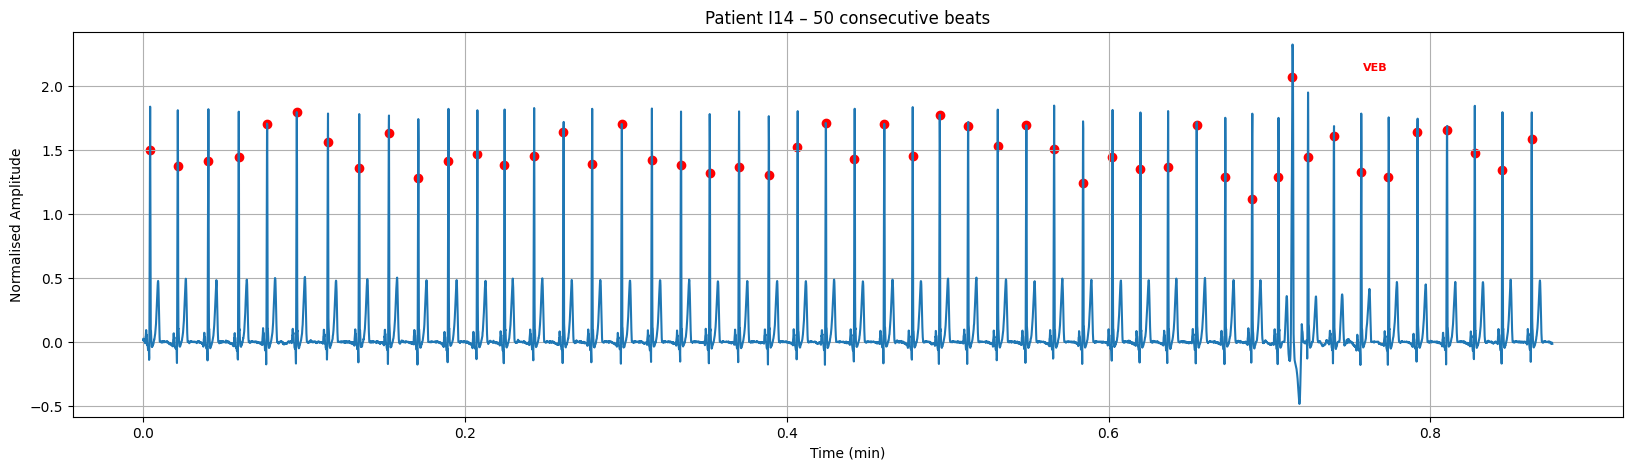

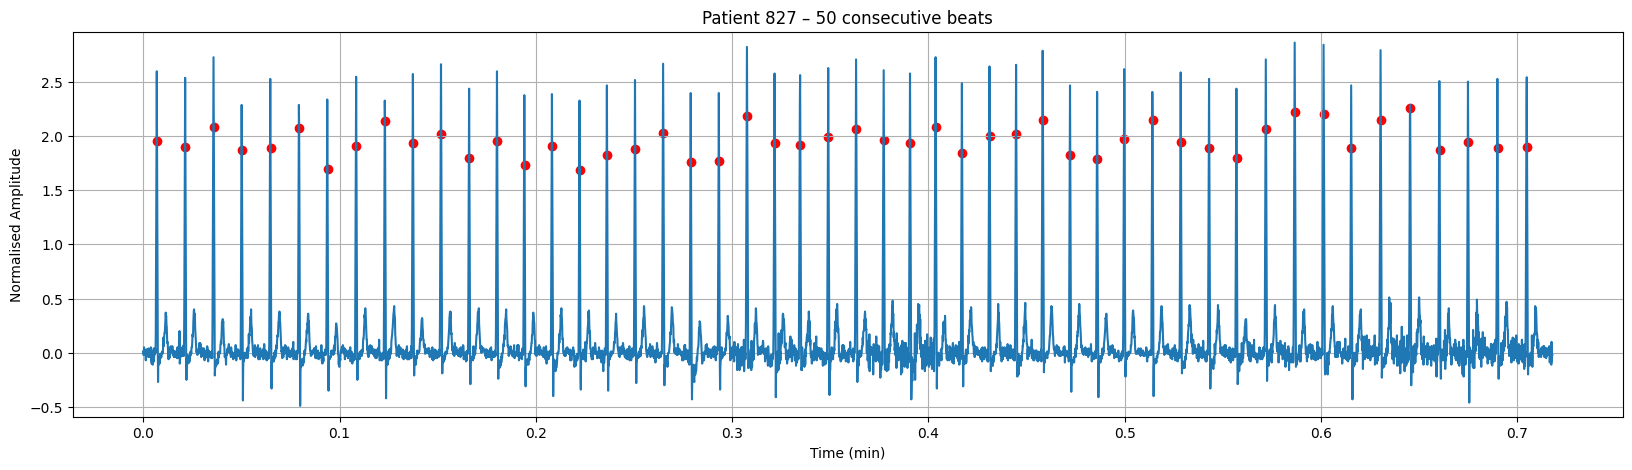

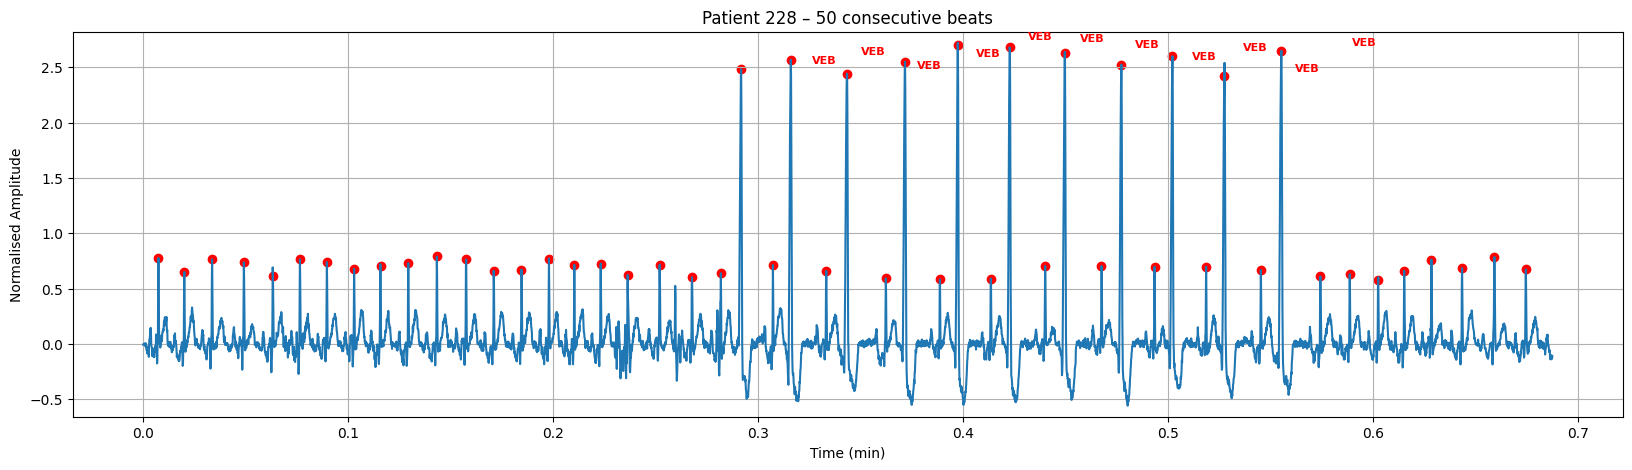

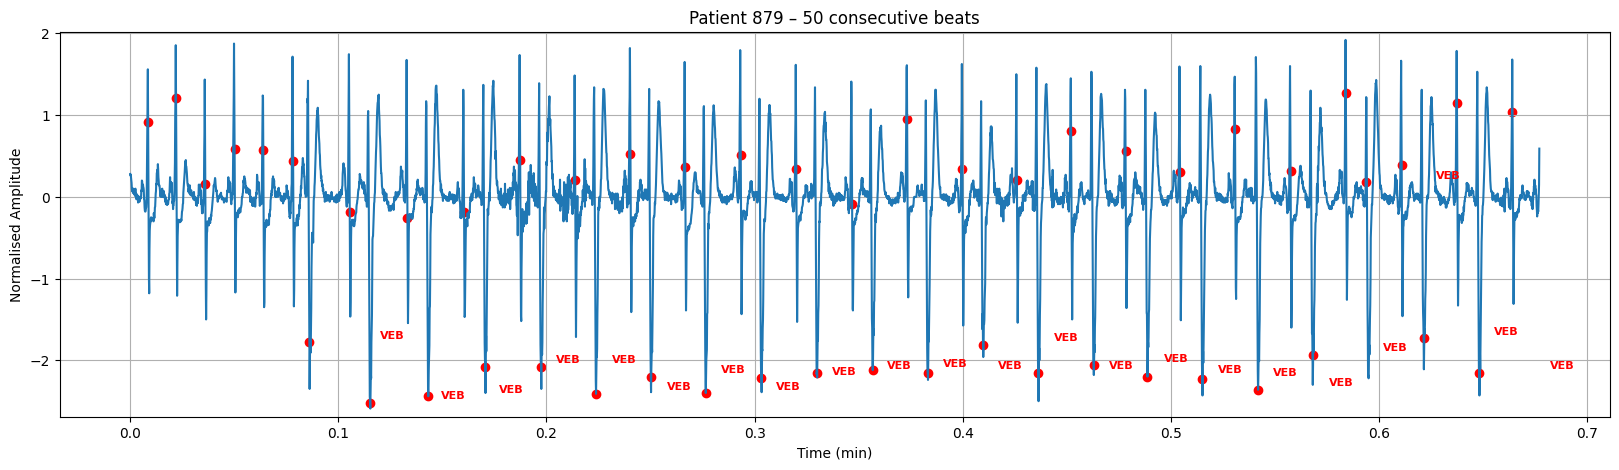

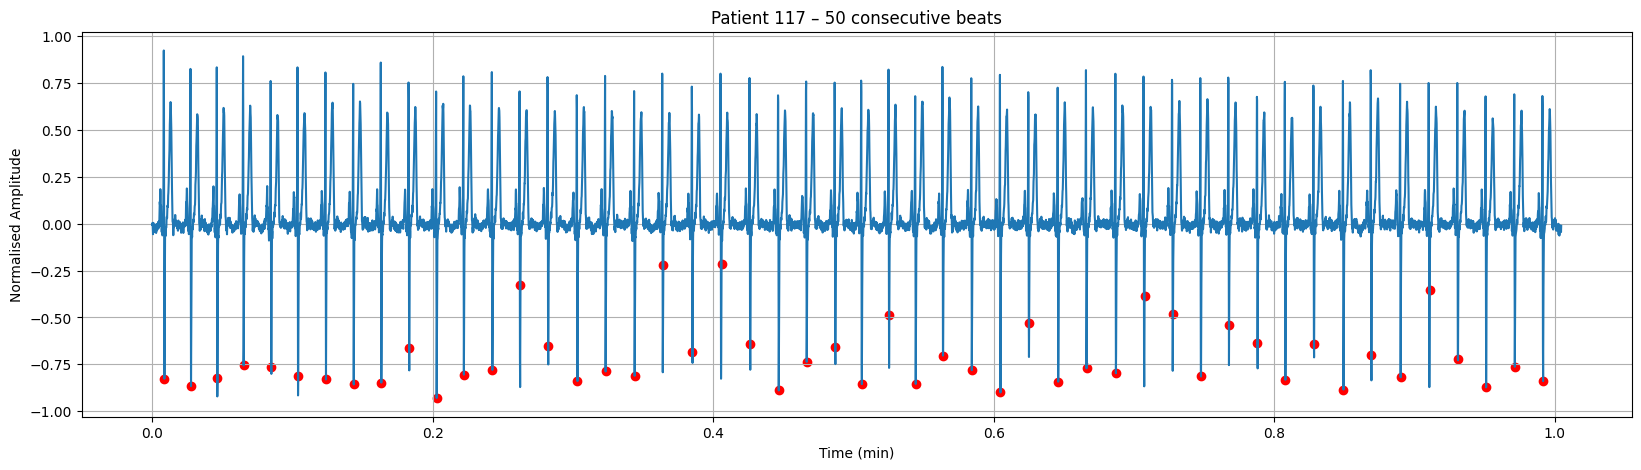

In [105]:
for pid, rec in selected:
  signal      = np.array(rec["signal"])
  beat_locs   = np.array(rec["beat_locs"], dtype=int)
  beat_labels = np.array(rec["beat_labels"], dtype=int)
  fs = rec["sampling_rate"]

  # take first 50 consecutive beats
  locs_block   = beat_locs[:50]
  labels_block = beat_labels[:50]

  # convert annotations to strings
  ann_block = [idx_to_class[str(int(l))] for l in labels_block]

  # add 100-sample padding on each side for visual clarity
  pad = 100
  start_sample = max(0, locs_block[0] - pad)
  end_sample   = min(len(signal), locs_block[-1] + pad)

  signal_sub = signal[start_sample:end_sample]

  # shift beat locations so they align with the cropped signal
  locs_sub = (locs_block - start_sample).astype(int)

  # plot
  title = f"Patient {pid} – 50 consecutive beats"
  plot_signal(
      signal_sub,
      title=title,
      sampling_rate=fs,
      beat_locations=locs_sub,
      beat_annotations=ann_block
  )


<br>

2. **Construct the beat-level dataset**

In [8]:
beat_waveforms = []   # list[(floats)]
beat_labels    = []   # list[int]

for rec in dataset["train"]:
    # get signal and annotations
    signal = np.array(rec["signal"])
    beat_locs = np.array(rec["beat_locs"], dtype=int)
    labels = list(rec["beat_labels"])   # ensure plain list

    # use helper to split into individual beats
    beats = split_by_beat(signal, beat_locs)   # returns list of segments

    # sanity check: one label per beat
    assert len(beats) == len(labels), "beat/label length mismatch"

    # Extend global lists
    for b, lab in zip(beats, labels):
        beat_waveforms.append(b.tolist())  # convert each beat to list[float]
        beat_labels.append(int(lab))       # store label as int


print(f"Total beats (samples) constructed: {len(beat_waveforms)}")
print(f"Length of beat_labels: {len(beat_labels)}")
print("Example beat length:", len(beat_waveforms[0]))
print("Example label:", beat_labels[0])


Total beats (samples) constructed: 461216
Length of beat_labels: 461216
Example beat length: 32
Example label: 0


<br>

3. **Apply a simple pre-processing filter**  

In [9]:
min_len = 32   # max heart rate 240 bpm
max_len = 256  # min heart rate 30 bpm

filtered_beats = []
filtered_labels = []
beat_lengths = []   # to use for the length histogram

for beat, lab in zip(beat_waveforms, beat_labels):
  L = len(beat)
  if min_len <= L <= max_len:
    filtered_beats.append(beat)
    filtered_labels.append(lab)
    beat_lengths.append(L)

print(f"Beats after filtering: {len(filtered_beats)}")
print(f"Removed: {len(beat_waveforms) - len(filtered_beats)}")
print("Example kept length:", beat_lengths[0])


Beats after filtering: 460885
Removed: 331
Example kept length: 32


<br>

4. **Plot summary statistics**

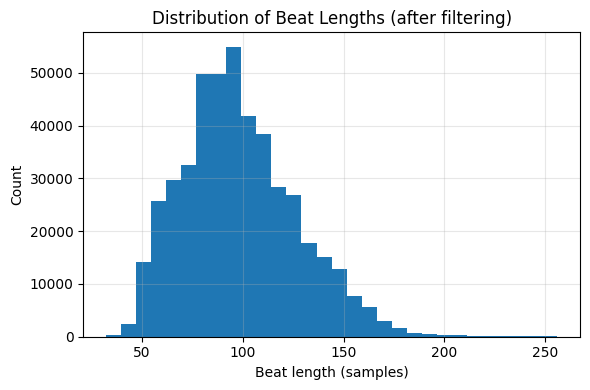

In [10]:

plt.figure(figsize=(6,4))
plt.hist(beat_lengths, bins=30)
plt.xlabel("Beat length (samples)")
plt.ylabel("Count")
plt.title("Distribution of Beat Lengths (after filtering)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

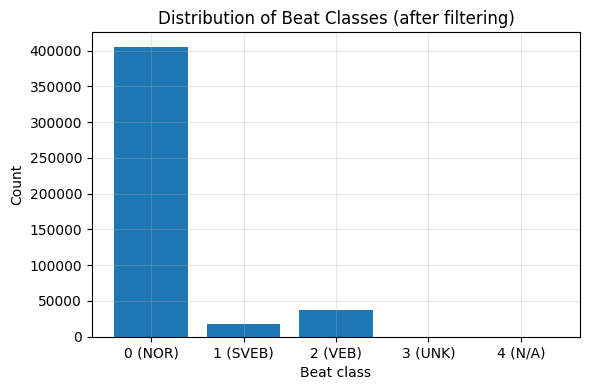

Label counts: Counter({0: 405489, 2: 38000, 1: 17300, 3: 96})


In [11]:

labels_arr = np.array(filtered_labels)

plt.figure(figsize=(6,4))
bins = np.arange(-0.5, 5.5, 1.0)  # centres bins on 0,1,2,3,4
plt.hist(labels_arr, bins=bins, rwidth=0.8)
plt.xticks(
    range(5),
    [f"{i} ({idx_to_class.get(str(i), 'N/A')})" for i in range(5)]
)
plt.xlabel("Beat class")
plt.ylabel("Count")
plt.title("Distribution of Beat Classes (after filtering)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Label counts:", Counter(filtered_labels))

<br><br>

## 2.B) Classification and Anomaly Detection

In this part you will build a supervised **beat-level classifier** using the segmented beats prepared in Part 2.A. Each beat is treated as an individual sample with a label in the simplified index space (0–4). Key points to consider:

- You should drop all beats with a label of **3** and only train the classifier for labels **0**, **1** and **2**. This will make the training easier, given the significant class imbalance.

- Beats naturally vary in duration, so you must decide how to convert them into a consistent representation suitable for a model. You are free to choose any reasonable approach; at the simplest level, you may choose to zero-pad beats to a fixed length, but more refined strategies are also acceptable.

- You are expected to design the full solution **yourself**: the model, the preprocessing pipeline, the train/validation splits, and the overall training procedure. You must also decide on **suitable evaluation metrics** for this problem.

- As established in Part 2.A, the dataset is **heavily imbalanced**, with normal beats dominating the distribution. This affects both training and evaluation: models that ignore imbalance tend to overfit normal beats while failing on minority abnormal classes. **Strong solutions will address imbalance explicitly and will aim to produce models that perform reliably across all classes, not only the majority one.** You are, therefore, required to report each validation metric twice: one for normal (0) and one for abnormal (1-2), separately.

- Only include code that is necessary to reproduce your results. Notebook organisation and clarity form part of the assessment (see the main *README*).

- You should ensure that the notebook clearly displays how your chosen **evaluation metric(s) evolve over training iterations or epochs.**

- You may include **up to two** solutions in this notebook, in recognition that partially working attempts may still receive marks under the criteria outlined in the *README*, but you are encouraged to start with a simple, reliable baseline before attempting a more complex model.


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

In [12]:
clean_beats = []
clean_labels = []

for beat, lab in zip(filtered_beats, filtered_labels):
    if lab != 3:                  # drop UNK
        clean_beats.append(beat)
        clean_labels.append(lab)

print("Beats kept (labels 0,1,2):", len(clean_beats))

Beats kept (labels 0,1,2): 460789


In [13]:
X = []
y = []

FIXED_LEN = 256

for beat, lab in zip(clean_beats, clean_labels):
    arr = np.array(beat)

    if len(arr) < FIXED_LEN:
        # zero pad on both sides
        pad_width = FIXED_LEN - len(arr)
        arr = np.pad(arr, (0, pad_width), mode='constant')

    X.append(arr)
    y.append(lab)

X = np.stack(X)   # shape: (N, 256)
y = np.array(y)   # shape: (N,)

In [14]:
Counter(y)


Counter({np.int64(0): 405489, np.int64(2): 38000, np.int64(1): 17300})

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_val.shape)

(368631, 256) (92158, 256)


In [162]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# (batch, channels, length) for Conv1d
X_train_t = torch.from_numpy(X_train).float().unsqueeze(1)  # (N, 1, 256)
y_train_t = torch.from_numpy(y_train).long()

X_val_t = torch.from_numpy(X_val).float().unsqueeze(1)
y_val_t = torch.from_numpy(y_val).long()

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)

batch_size = 256

class_counts = Counter(y_train)
weights = np.array([1.0 / class_counts[y] for y in y_train])
sampler = torch.utils.data.WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

cuda


In [182]:
import torch.nn as nn
import torch.nn.functional as F

class BeatCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.gap = nn.AdaptiveAvgPool1d(1)  # global avg pool
        self.fc = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.gap(x).squeeze(-1)          # (batch, 64)
        x = self.dropout(x)
        x = self.fc(x)                       # (batch, 3)
        return x

model = BeatCNN(num_classes=3).to(device)
model


BeatCNN(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [206]:
class PaperCNN1D(nn.Module):
    def __init__(self, num_classes=3, dropout_p=0.5, pool_len=7):
        super().__init__()

        # Conv blocks (paper: Conv -> MaxPool -> Conv -> MaxPool)
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Make flatten size stable
        self.gap = nn.AdaptiveAvgPool1d(pool_len)  # output: (B, 64, pool_len)

        # FC stack (paper: 500 -> 256 -> 64 -> out)
        self.fc1 = nn.Linear(64 * pool_len, 500)
        self.drop = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 64)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (B, 1, 256)
        x = self.pool(F.relu(self.conv1(x)))   # (B, 32, 128)
        x = self.pool(F.relu(self.conv2(x)))   # (B, 64, 64)

        x = self.gap(x)                        # (B, 64, pool_len)
        x = x.flatten(1)                       # (B, 64*pool_len)

        x = self.drop(F.relu(self.fc1(x)))     # (B, 500)
        x = F.relu(self.fc2(x))                # (B, 256)
        x = F.relu(self.fc3(x))                # (B, 64)
        logits = self.out(x)                   # (B, 3)

        return logits

model = PaperCNN1D(num_classes=3).to(device)
model


PaperCNN1D(
  (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool1d(output_size=7)
  (fc1): Linear(in_features=448, out_features=500, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=3, bias=True)
)

In [207]:
class_counts = Counter(y_train)
print(class_counts)

# inverse-frequency weights
num_classes = 3
total = sum(class_counts[c] for c in range(num_classes))
weights = np.array([total / class_counts[c] for c in range(num_classes)], dtype=np.float32)
print("class weights:", weights)

class_weights = torch.tensor(weights, device=device)

# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()

# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2):
#         super().__init__()
#         self.gamma = gamma
#         self.ce = nn.CrossEntropyLoss(reduction='none')

#     def forward(self, logits, targets):
#         ce_loss = self.ce(logits, targets)
#         pt = torch.exp(-ce_loss)
#         loss = ((1 - pt) ** self.gamma) * ce_loss
#         return loss.mean()

# criterion = FocalLoss()

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='max', factor=0.5, patience=2
# )

Counter({np.int64(0): 324391, np.int64(2): 30400, np.int64(1): 13840})
class weights: [ 1.1363786 26.635187  12.1260195]


In [254]:
def training(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    for inputs, targets in loader:          # <--- (x, y) from DataLoader
        inputs = inputs.float().to(device)  # (batch, 1, 256)
        targets = targets.long().to(device) # (batch,)

        optimizer.zero_grad()
        logits = model(inputs)              # (batch, 3)
        loss = criterion(logits, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)

        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

    avg_loss = total_loss / len(loader.dataset)

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # macro F1 over classes 0,1,2
    macro_f1 = f1_score(all_targets, all_preds, average="macro", labels=[0,1,2], zero_division=0)
    # macro_f1 = f1_score(all_targets, all_preds, average="macro")

    # binary F1: normal (0) vs abnormal (1,2)
    y_true_bin = (all_targets != 0).astype(int)
    y_pred_bin = (all_preds   != 0).astype(int)

    # bin_f1 = f1_score(y_true_bin, y_pred_bin)
    bin_f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)

    return avg_loss, macro_f1, bin_f1


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.float().to(device)
            targets = targets.long().to(device)

            logits = model(inputs)
            loss = criterion(logits, targets)

            total_loss += loss.item() * inputs.size(0)

            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    avg_loss = total_loss / len(loader.dataset)

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # macro_f1 = f1_score(all_targets, all_preds, average="macro")
    macro_f1 = f1_score(all_targets, all_preds, average="macro", labels=[0,1,2], zero_division=0)

    y_true_bin = (all_targets != 0).astype(int)
    y_pred_bin = (all_preds   != 0).astype(int)

    # bin_f1 = f1_score(y_true_bin, y_pred_bin)
    bin_f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)

    return avg_loss, macro_f1, bin_f1

In [209]:
# mount drive to periodically save model during training
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [210]:
import wandb

nepochs = 10

run = wandb.init(
    project="DL_Assessment_Q2",
    # entity="francesco-remondi25",
    config={
        "learning_rate": lr,
        "architecture": "PaperCNN",
        "batch_size": batch_size,
        "epochs": nepochs,
        "optimiser": "adam",
        "lr_scheduler": "on",
        "criterion": "CELoss (not balanced)",
        "norm": "batchnorm2d",
        "dropout": "off",
        "weight_sampler": "on"

    }
)

!mkdir '/content/drive/My Drive/Q2_models'  # create the director for storing the model in Google Drive

model_save_name = 'CNN_model.pt'           # .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/drive/My Drive/models/{model_save_name}" # use this to store in your Google Drive storage

mkdir: cannot create directory ‘/content/drive/My Drive/Q2_models’: File exists


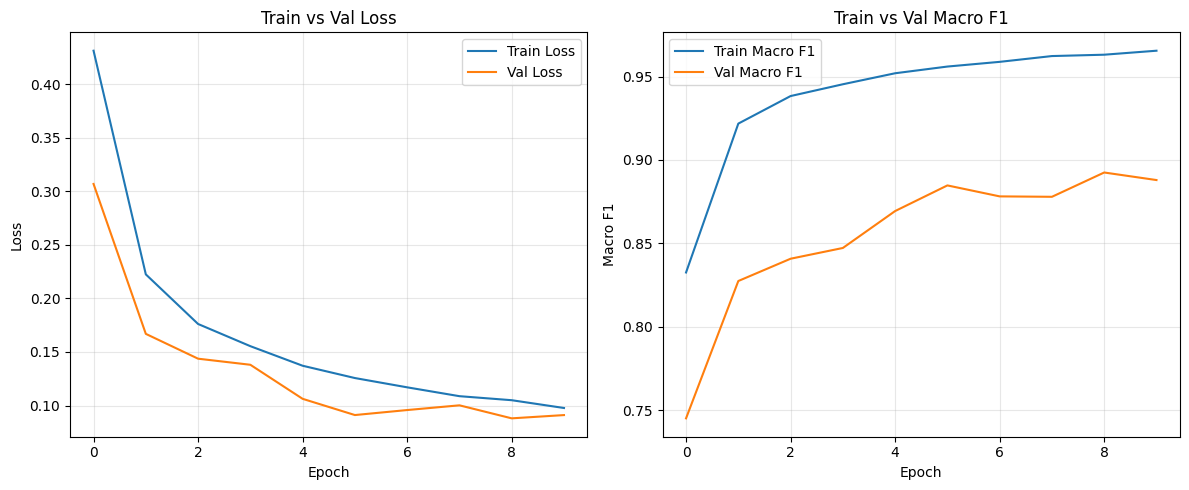

Epoch 10/10 | train_loss=0.0977, val_loss=0.0911 | train_macroF1=0.966, val_macroF1=0.888 | train_F1_norm-vs-abn=0.983, val_F1_norm-vs-abn=0.887


train_loss,█▄▃▂▂▂▁▁▁▁
train_macro_f1,▁▆▇▇▇▇████
val_loss,█▄▃▃▂▁▁▁▁▁
val_macro_f1,▁▅▆▆▇█▇▇██
train_loss,0.09768
train_macro_f1,0.96556
val_loss,0.09107
val_macro_f1,0.88796


In [211]:
from IPython.display import clear_output

num_epochs = 10

train_losses, val_losses = [], []
train_macro_f1s, val_macro_f1s = [], []
train_bin_f1s, val_bin_f1s = [], []

for epoch in range(num_epochs):
    train_loss, train_macro_f1, train_bin_f1 = training(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_macro_f1, val_bin_f1 = validate(
        model, val_loader, criterion, device
    )

    # scheduler.step(val_macro_f1)

    # store
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_macro_f1s.append(train_macro_f1)
    val_macro_f1s.append(val_macro_f1)
    train_bin_f1s.append(train_bin_f1)
    val_bin_f1s.append(val_bin_f1)

    torch.save(model.state_dict(), path)
    run.log({"train_loss": train_loss, "val_loss": val_loss,
             "train_macro_f1": train_macro_f1, "val_macro_f1": val_macro_f1})

    # live plots
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # LEFT: Loss
    axes[0].plot(train_losses, label="Train Loss")
    axes[0].plot(val_losses, label="Val Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Train vs Val Loss")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # RIGHT: Macro F1
    axes[1].plot(train_macro_f1s, label="Train Macro F1")
    axes[1].plot(val_macro_f1s, label="Val Macro F1")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Macro F1")
    axes[1].set_title("Train vs Val Macro F1")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(
        f"Epoch {epoch+1:02d}/{num_epochs} | "
        f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f} | "
        f"train_macroF1={train_macro_f1:.3f}, val_macroF1={val_macro_f1:.3f} | "
        f"train_F1_norm-vs-abn={train_bin_f1:.3f}, val_F1_norm-vs-abn={val_bin_f1:.3f}"
    )

run.finish()

In [188]:
class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # we will streamline the implementation of the LSTM by combining the
        # weights for all 4 operations (input gate, forget gate, output gate, candidate update)
        self.i2h = nn.Linear(input_size, hidden_size * 4, bias=bias)       # create a linear layer to map from input to hidden space
        self.h2h = nn.Linear(hidden_size, hidden_size * 4, bias=bias)      # create a linear layer to map from previous to current hidden space

        self.reset_parameters()                                            # initialise the parameters

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)

        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, h, c):
        gates = self.i2h(input) + self.h2h(h)                              # apply the weights to both input and previous state

        input_gate, forget_gate, candidate_update, output_gate = gates.chunk(4, 1)  # separate the output into each of the LSTM operations

        # apply the corresponding activations
        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        c_t = torch.tanh(candidate_update)
        o_t = torch.sigmoid(output_gate)

        c = f_t * c + i_t * c_t                                             # calculate the next cell state

        h = o_t * torch.tanh(c)                                             # calculate the next hidden state

        return h, c

In [189]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, bias=False):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.rnn_cell_list = nn.ModuleList()                         # create a list of modules

        # create each layer in the network
        # take care when defining the input size of the first vs later layers
        for l in range(self.num_layers):
            self.rnn_cell_list.append(LSTMCell(self.input_size if l == 0 else self.hidden_size,
                                               self.hidden_size,
                                               self.bias))

        self.h2o = nn.Linear(self.hidden_size, self.output_size)     # create a final linear layer from hidden state to network output

    def init_hidden(self,  batch_size=1):
        # initialise the hidden state and cell state
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device))

    def forward(self, input, h0, c0):
        # Input of shape (batch_size, seqence length , input_size)
        # Output of shape (batch_size, output_size)

        outs = []

        hidden = []
        cell = []
        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])
            cell.append(c0[layer, :, :])

        # iterate over all elements in the sequence
        for t in range(input.size(1)):
            # iterate over each layer
            for layer in range(self.num_layers):
                # apply each layer
                # take care to apply the layer to the input or the
                # previous hidden state depending on the layer number
                if layer == 0:
                    hidden_l, cell_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer], cell[layer])
                else:
                    hidden_l, cell_l = self.rnn_cell_list[layer](hidden[layer-1], hidden[layer], cell[layer])

                # store the hidden and cell state of each layer
                hidden[layer] = hidden_l
                cell[layer] = cell_l

            # the hidden state of the last layer needs to be recorded
            # to be used in the output
            outs.append(hidden_l)

        # calculate output for each element in the sequence
        out = torch.stack([self.h2o(out) for out in outs], dim=1)

        return out

In [227]:
# class BeatLSTMClassifierCNN(nn.Module):
#     def __init__(self, num_classes=4, lstm_hidden=128, lstm_layers=3, dropout_p=0.5, bias=True):
#         super().__init__()

#         1D CNN
#         self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
#         self.pool1 = nn.MaxPool1d(2)

#         self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
#         self.pool2 = nn.MaxPool1d(2)

#         self.lstm = LSTM(
#             input_size=64,              # CNN feature channels become per-timestep features
#             hidden_size=lstm_hidden,     # 128
#             num_layers=lstm_layers,      # 3
#             output_size=lstm_hidden,
#             bias=bias
#         )

#         self.dropout = nn.Dropout(dropout_p)
#         self.fc = nn.Linear(lstm_hidden, num_classes)  # 4 neurons

#     def forward(self, x):

#         x = self.pool1(F.relu(self.conv1(x))) # (B,32,L/2)
#         x = self.pool2(F.relu(self.conv2(x))) # (B,64,L/4)

#         # ---- CNN output -> LSTM sequence ----
#         # LSTM expects (B, T, input_size)
#         x = x.transpose(1, 2)                 # (B, T, 64)

#         B = x.size(0)
#         h0, c0 = self.lstm.init_hidden(B)
#         out_seq = self.lstm(x, h0, c0)        # (B, T, 128)

#         # Use last timestep (paper-like)
#         feat = out_seq[:, -1, :]              # (B,128)

#         feat = self.dropout(feat)
#         logits = self.fc(feat)                # (B,4)
#         return logits

In [228]:
# class BeatLSTMClassifier(nn.Module):
#     def __init__(self, input_size=1, hidden_size=64, num_layers=1, num_classes=3, bias=True, pool_len=7):
#         super().__init__()


#         self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
#         self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
#         self.pool  = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.gap   = nn.AdaptiveAvgPool1d(pool_len)

#         self.lstm = LSTM(
#             input_size=64,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             output_size=hidden_size,     # keep output_size = hidden_size
#             bias=bias
#         )

#         self.fc = nn.Linear(hidden_size, num_classes)
#         self.dropout = nn.Dropout(0.3)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))   # (B,32,128)
#         x = self.pool(F.relu(self.conv2(x)))   # (B,64,64)

#         x = self.gap(x)                        # (B,64,pool_len)
#         x = x.transpose(1, 2)                  # (B,pool_len,64) sequence for LSTM

#         B = x.size(0)
#         h0, c0 = self.lstm.init_hidden(B)

#         out_seq = self.lstm(x, h0, c0)

#         last_hidden = out_seq[:, -1, :]
#         last_hidden = self.dropout(last_hidden)
#         logits = self.fc(last_hidden)

#         return logits


In [248]:
class MultiheadedAttention(nn.Module):

    def __init__(self, dim, num_heads=8, attention_dropout=0.1, projection_dropout=0.1):
        super().__init__()

        self.num_heads = num_heads
        head_dim = dim // num_heads    # Divide dimension across heads
        self.scale = head_dim ** -0.5  # Scaling to be used for <q,v> dot product

        self.qkv = nn.Linear(dim, dim * 3)                 # 3*dim to account for q, k, v matrices
        self.attn_dropout = nn.Dropout(attention_dropout)  # Add dropout

        self.projection = nn.Linear(dim, dim)              # Add linear layer
        self.activation = nn.GELU()                        # And a GELU activation
        self.proj_dropout = nn.Dropout(projection_dropout) # Final dropout

    def forward(self, x):
        # Separate q, v, k matrices
        B, N, C = x.shape
        qkv = (
            self.qkv(x) # B, N, (3*C)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads) # B, N, 3(qkv), H(eads), embed_dim
            .permute(2, 0, 3, 1, 4)                                # 3, B, H(eads), N, emb_dim
            .reshape(3, B*self.num_heads, N, C // self.num_heads)  # 3, B*H(eads), N, emb_dim
        )
        q, k, v = torch.chunk(qkv, 3)                              # B, H*N, dim
        q, k, v = q.squeeze(0), k.squeeze(0), v.squeeze(0)         # Extract matrices

        # Calculate the dot product of q and k and softmax the result
        # B*H,N,dim x B*H,dim,N -> B*H,N,N
        attn = torch.bmm(q, k.transpose(-2, -1)) * self.scale # <q,k> / sqrt(d)
        attn = attn.softmax(dim=-1)                           # Softmax over embedding dim
        attn = self.attn_dropout(attn)                        # Dropout

        # Multiply the result by v and reshape appropriately
        # B*H, N, N
        x = (
            torch.bmm(attn, v)                                  # B*H,N,N x B*H,N,dim -> B*H,N,dim
            .reshape(B, self.num_heads, N, C // self.num_heads) # B, H, N, dim
            .transpose(1, 2)                                    # B, N, H, dim
            .reshape(B, N, C)                                   # B, N, (H*dim)
        )

        # Apply a linear operation
        x = self.projection(x)   # Apply linear layer
        x = self.activation(x)   # Apply activation
        x = self.proj_dropout(x) # Apply dropout

        return x

In [249]:
class MHABlock1D(nn.Module):
    def __init__(self, channels, num_heads=8, attn_drop=0.1, proj_drop=0.1):
        super().__init__()
        assert channels % num_heads == 0, "channels must be divisible by num_heads"

        self.norm = nn.LayerNorm(channels)
        self.mha = MultiheadedAttention(
            dim=channels,
            num_heads=num_heads,
            attention_dropout=attn_drop,
            projection_dropout=proj_drop
        )

    def forward(self, x):
        # x: (B, C, T)
        x_seq = x.transpose(1, 2)          # (B, T, C)
        x_seq = x_seq + self.mha(self.norm(x_seq))  # residual
        return x_seq.transpose(1, 2)       # (B, C, T)

In [261]:
class PaperCNN1D_MHA(nn.Module):
    def __init__(self, num_classes=3, dropout_p=0.5, pool_len=7):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)

        self.pool = nn.MaxPool1d(2, 2)

        # Multi-head attention on (B,64,T)
        self.attn = MHABlock1D(channels=64, num_heads=8, attn_drop=0.1, proj_drop=0.1)

        self.gap = nn.AdaptiveAvgPool1d(pool_len)

        # FC head
        self.fc1 = nn.Linear(64 * pool_len, 500)
        self.drop = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 64)
        self.out = nn.Linear(64, num_classes)

        self.ln1 = nn.LayerNorm(500)
        self.ln2 = nn.LayerNorm(256)
        self.ln3 = nn.LayerNorm(64)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # (B,32,128)
        x = F.relu(self.bn2(self.conv2(x)))             # (B,64,128)

        x = self.attn(x)                                # (B,64,128)

        x = self.pool(x)                                # (B,64,64)
        x = self.gap(x)                                 # (B,64,pool_len)

        x = x.flatten(1)
        x = self.drop(F.relu(self.ln1(self.fc1(x))))
        x = F.relu(self.ln2(self.fc2(x)))
        x = F.relu(self.ln3(self.fc3(x)))
        return self.out(x)

model = PaperCNN1D_MHA().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [262]:
run = wandb.init(
    project="DL_Assessment_Q2_LSTM",
    # entity="francesco-remondi25",
    config={
        "learning_rate": lr,
        "architecture": "PaperCNN_MHAattn",
        "batch_size": batch_size,
        "epochs": nepochs,
        "optimiser": "adam",
        "lr_scheduler": "off",
        "criterion": "CE",
        "dropout": "off",
        "batch_norm": "on"

    }
)

!mkdir '/content/drive/My Drive/Q2_models'  # create the director for storing the model in Google Drive

model_save_name = 'LSTM_model.pt'           # .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/drive/My Drive/models/{model_save_name}" # use this to store in your Google Drive storage

train_loss,▁▃█
train_macro_f1,█▇▁
val_loss,▁█▃
val_macro_f1,▄▁█
train_loss,1.13736
train_macro_f1,0.2998
val_loss,1.26784
val_macro_f1,0.12285


mkdir: cannot create directory ‘/content/drive/My Drive/Q2_models’: File exists


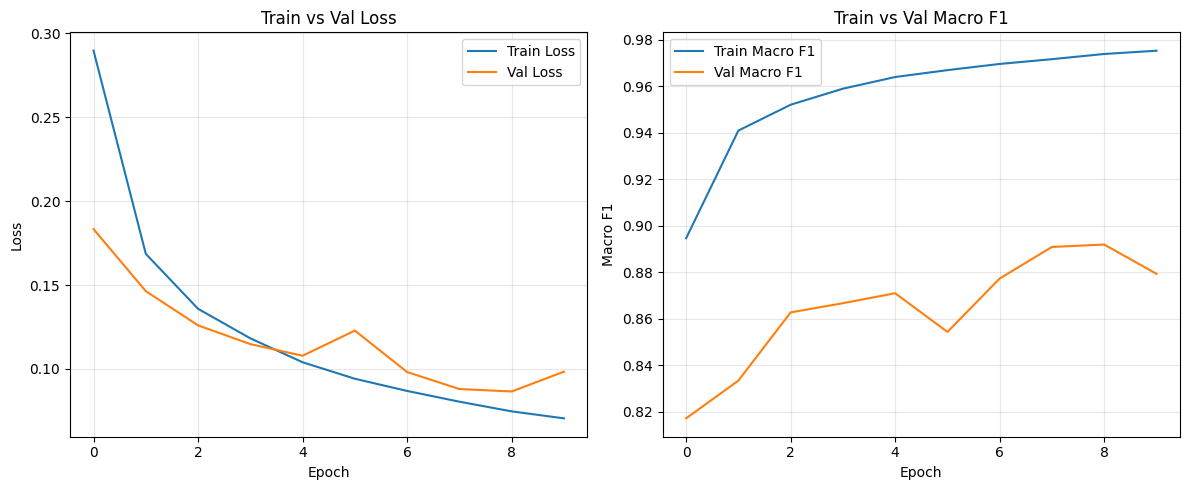

Epoch 10/10 | train_loss=0.0706, val_loss=0.0984 | train_macroF1=0.975, val_macroF1=0.879 | train_F1_norm-vs-abn=0.987, val_F1_norm-vs-abn=0.881


train_loss,█▄▃▃▂▂▂▁▁▁
train_macro_f1,▁▅▆▇▇▇████
val_loss,█▅▄▃▃▄▂▁▁▂
val_macro_f1,▁▃▅▆▆▄▇██▇
train_loss,0.07055
train_macro_f1,0.97533
val_loss,0.09836
val_macro_f1,0.87941


In [263]:
num_epochs = 10

train_losses, val_losses = [], []
train_macro_f1s, val_macro_f1s = [], []
train_bin_f1s, val_bin_f1s = [], []

for epoch in range(num_epochs):
    train_loss, train_macro_f1, train_bin_f1 = training(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_macro_f1, val_bin_f1 = validate(
        model, val_loader, criterion, device
    )

    # store
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_macro_f1s.append(train_macro_f1)
    val_macro_f1s.append(val_macro_f1)
    train_bin_f1s.append(train_bin_f1)
    val_bin_f1s.append(val_bin_f1)

    torch.save(model.state_dict(), path)
    run.log({"train_loss": train_loss, "val_loss": val_loss,
             "train_macro_f1": train_macro_f1, "val_macro_f1": val_macro_f1})

    # live plots
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # LEFT: Loss
    axes[0].plot(train_losses, label="Train Loss")
    axes[0].plot(val_losses, label="Val Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Train vs Val Loss")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # RIGHT: Macro F1
    axes[1].plot(train_macro_f1s, label="Train Macro F1")
    axes[1].plot(val_macro_f1s, label="Val Macro F1")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Macro F1")
    axes[1].set_title("Train vs Val Macro F1")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(
        f"Epoch {epoch+1:02d}/{num_epochs} | "
        f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f} | "
        f"train_macroF1={train_macro_f1:.3f}, val_macroF1={val_macro_f1:.3f} | "
        f"train_F1_norm-vs-abn={train_bin_f1:.3f}, val_F1_norm-vs-abn={val_bin_f1:.3f}"
    )

run.finish()

<br><br>

## 2.C) Discussion (max 250 words)

Reflect critically on your solution to Part 2.B. In your discussion, address the following points:

1. **Modelling choices**

   Explain the main decisions behind your model design(s) and why you believe these choices are suitable for this task.

2. **Performance and validation**
   
   Interpret your model’s performance on normal versus abnormal beats using the evaluation metrics you selected. Comment on how class imbalance affected the results and what strategies you have sought to mitigate its impact.

3. **Limitations and improvements**
   
   Identify the main limitations of your approach and outline specific steps that could meaningfully improve performance. You may refer to architectural changes, alternative representations, different imbalance-handling strategies, or improved validation schemes.

Your answer should be technically focused, directly address these points, and remain within the stated word limit. Overly long or off-topic discussions will be penalised.


<br>

---

<br>

Main decisions behind architecture modeling were taken from "Deep Learning Models for Arrhythmia Classification Using Stacked Time-frequency Scalogram Images from ECG Signals". In particular, their simpler 1dCNN model was used as a base one.

Next, a ore advance hybrid model is proposed, using both 1dCNN and LSTM architecture.



<br>

---

<br>